# Final Project: Identify Influential Bogs & Make Profits for TechCrunch
### Group Super Duper: Yuanyuan Ge, Joey Li, Yijun Huang,Yining Hang, Yiying Wang

#### This notebook takes data of 107 authors, their 19464 posts and all 746561 comments and performed following analysis with Pyspark:
* Topic Modeling on Posts
* Comments Sentiment Analysis
* Writing Style Identification
* Regression with MLlib


In [2]:
# First of all import all required packages:

import numpy as np
import pandas as pd
import re
from pprint import pprint
import scipy
from textblob import TextBlob # Import TextBlob packages for Sentiment Analysis
import collections as coll
import math
import pickle
import string
import matplotlib.pyplot as plt
from matplotlib import style

import nltk
nltk.download('cmudict')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import cmudict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import pyspark as ps
from pyspark.sql import functions as F
from pyspark.sql import SparkSession 
from pyspark.sql.types import DoubleType, FloatType, StringType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.window import Window
from pyspark.sql.functions import *
from pyspark.sql.functions import col, udf
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
import org.apache.spark.ml.feature.CountVectorizer
import org.apache.spark.mllib.linalg.Vector
import org.apache.spark.mllib.clustering.LDA, nlineLDAOptimizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

%matplotlib inline
%load_ext autotime

[nltk_data] Downloading package cmudict to
[nltk_data]     C:\Users\lzzse\AppData\Roaming\nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lzzse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lzzse\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
conf = ps.SparkConf().setMaster("yarn-client").setAppName("sparK-mer")
conf.set("spark.driver.memory", "15g")
conf.set("spark.executor.heartbeatInterval","3600s")

spark = SparkSession\
        .builder\
        .appName('final')\
        .getOrCreate()

time: 5 ms


# Comments Sentiment Analysis

### Load the comments data

In [4]:
comments = spark.read.format("csv").option("header", "false").load("comments.csv")

In [5]:
comments = comments.withColumnRenamed("_c0", "Comment ID")\
        .withColumnRenamed("_c1", "Post ID")\
        .withColumnRenamed("_c2", "Content")\
        .withColumnRenamed("_c3", "Author")\
        .withColumnRenamed("_c4", "Date")\
        .withColumnRenamed("_c5", "Vote")

In [6]:
comments.show(5)

+----------+-------+--------------------+--------------+----------+----+
|Comment ID|Post ID|             Content|        Author|      Date|Vote|
+----------+-------+--------------------+--------------+----------+----+
|         1|      1|Seemed to work fine.|       BJ Cook|2010-04-01|   1|
|         2|      1|I tried this the ...|  Blitz Surfer|2010-04-01|   1|
|         3|      1|A lot of twitter ...|Nischal Shetty|2010-04-01|   1|
|         4|      1|Worked a minute a...|   Jonah Grant|2010-04-01|   1|
|         5|      1|Yep. At 10:33pm p...| Joshua Guffey|2010-04-01|   1|
+----------+-------+--------------------+--------------+----------+----+
only showing top 5 rows



In [7]:
comments = comments.dropna()

In [8]:
comments.count()

745866

### Text Preprocessing

#### Fixed abbreviation

In [12]:
def fix_abbreviation(data_str):
    data_str = data_str.lower()
    data_str = re.sub(r'\bthats\b', 'that is', data_str)
    data_str = re.sub(r'\bive\b', 'i have', data_str)
    data_str = re.sub(r'\bim\b', 'i am', data_str)
    data_str = re.sub(r'\bya\b', 'yeah', data_str)
    data_str = re.sub(r'\bcant\b', 'can not', data_str)
    data_str = re.sub(r'\bdont\b', 'do not', data_str)
    data_str = re.sub(r'\bwont\b', 'will not', data_str)
    data_str = re.sub(r'\bid\b', 'i would', data_str)
    data_str = re.sub(r'wtf', 'what the fuck', data_str)
    data_str = re.sub(r'\bwth\b', 'what the hell', data_str)
    data_str = re.sub(r'\br\b', 'are', data_str)
    data_str = re.sub(r'\bu\b', 'you', data_str)
    data_str = re.sub(r'\bk\b', 'OK', data_str)
    data_str = re.sub(r'\bsux\b', 'sucks', data_str)
    data_str = re.sub(r'\bno+\b', 'no', data_str)
    data_str = re.sub(r'\bcoo+\b', 'cool', data_str)
    data_str = re.sub(r'rt\b', '', data_str)
    data_str = data_str.strip()
    return data_str

fix_abbreviation_udf = F.udf(fix_abbreviation, StringType())

In [13]:
comments = comments.withColumn('fixed_abbrev',fix_abbreviation_udf(comments['Content']))
comments.show(5)

+----------+-------+--------------------+--------------+----------+----+--------------------+
|Comment ID|Post ID|             Content|        Author|      Date|Vote|        fixed_abbrev|
+----------+-------+--------------------+--------------+----------+----+--------------------+
|         1|      1|Seemed to work fine.|       BJ Cook|2010-04-01|   1|seemed to work fine.|
|         2|      1|I tried this the ...|  Blitz Surfer|2010-04-01|   1|i tried this the ...|
|         3|      1|A lot of twitter ...|Nischal Shetty|2010-04-01|   1|a lot of twitter ...|
|         4|      1|Worked a minute a...|   Jonah Grant|2010-04-01|   1|worked a minute a...|
|         5|      1|Yep. At 10:33pm p...| Joshua Guffey|2010-04-01|   1|yep. at 10:33pm p...|
+----------+-------+--------------------+--------------+----------+----+--------------------+
only showing top 5 rows



#### Remove irrelevant features

In [14]:
def remove_features(data_str):
    # compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?')
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    # convert to lowercase
    data_str = data_str.lower()
    # remove hyperlinks
    data_str = url_re.sub(' ', data_str)
    # remove @mentions
    data_str = mention_re.sub(' ', data_str)
    # remove puncuation
    data_str = punc_re.sub(' ', data_str)
    # remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    # remove non a-z 0-9 characters and words shorter than 1 characters
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
        list_pos += 1
    # remove unwanted space, *.split() will automatically split on
    # whitespace and discard duplicates, the " ".join() joins the
    # resulting list into one string.
    return " ".join(cleaned_str.split())

remove_features_udf = F.udf(remove_features, StringType())

In [16]:
comments = comments.withColumn('removed',remove_features_udf(comments['Content']))
comments.show(5, True)

+----------+-------+--------------------+--------------+----------+----+--------------------+--------------------+
|Comment ID|Post ID|             Content|        Author|      Date|Vote|        fixed_abbrev|             removed|
+----------+-------+--------------------+--------------+----------+----+--------------------+--------------------+
|         1|      1|Seemed to work fine.|       BJ Cook|2010-04-01|   1|seemed to work fine.| seemed to work fine|
|         2|      1|I tried this the ...|  Blitz Surfer|2010-04-01|   1|i tried this the ...|tried this the fi...|
|         3|      1|A lot of twitter ...|Nischal Shetty|2010-04-01|   1|a lot of twitter ...|lot of twitter ap...|
|         4|      1|Worked a minute a...|   Jonah Grant|2010-04-01|   1|worked a minute a...|worked minute ago...|
|         5|      1|Yep. At 10:33pm p...| Joshua Guffey|2010-04-01|   1|yep. at 10:33pm p...|yep at pm pst it ...|
+----------+-------+--------------------+--------------+----------+----+--------

### Sentiment Analysis main function

In [18]:
def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

sentiment_analysis_udf = F.udf(sentiment_analysis , FloatType())

In [19]:
comments  = comments.withColumn("sentiment_score", sentiment_analysis_udf( comments['fixed_abbrev'] ))
comments = comments.drop('fixed_abbrev').drop('removed')
comments.show(5,True)

+----------+-------+--------------------+--------------+----------+----+---------------+
|Comment ID|Post ID|             Content|        Author|      Date|Vote|sentiment_score|
+----------+-------+--------------------+--------------+----------+----+---------------+
|         1|      1|Seemed to work fine.|       BJ Cook|2010-04-01|   1|     0.41666666|
|         2|      1|I tried this the ...|  Blitz Surfer|2010-04-01|   1|          0.125|
|         3|      1|A lot of twitter ...|Nischal Shetty|2010-04-01|   1|            0.5|
|         4|      1|Worked a minute a...|   Jonah Grant|2010-04-01|   1|            0.0|
|         5|      1|Yep. At 10:33pm p...| Joshua Guffey|2010-04-01|   1|     0.20888889|
+----------+-------+--------------------+--------------+----------+----+---------------+
only showing top 5 rows



### Get the Average Sentiment Score for each Post

In [23]:
post_sentiment= comments.groupBy(['Post ID']).agg(F.avg('sentiment_score').alias('avg_senti_score'))

In [24]:
post_sentiment.show(5)

+-------+-------------------+
|Post ID|    avg_senti_score|
+-------+-------------------+
|    675| 0.0335309744157173|
|   5925|0.11772260677231394|
|    691|0.11745779495686293|
|   6194| 0.1919174811582228|
|   6240|0.13226061725081542|
+-------+-------------------+
only showing top 5 rows



In [25]:
post_sentiment.toPandas().to_csv('post_sentiment.csv')

# Topic Modeling on Posts
#### Perform topic modeling on all posts and for each post, assign a topic. The results will be output as post_topicmodeling.csv

In [101]:
post1 = spark.read.format("csv").option("header", "false").load("posts.csv")

time: 237 ms


In [103]:
post11 = post1.withColumnRenamed("_c0", "Post ID")\
        .withColumnRenamed("_c1", "Title")\
        .withColumnRenamed("_c2", "Author")\
        .withColumnRenamed("_c3", "BloggerID")\
        .withColumnRenamed("_c4", "num_of_comments")\
        .withColumnRenamed("_c5", "content")\
        .withColumnRenamed("_c6", "URL")\

time: 31.3 ms


In [114]:
# Give tokens for each post
regexTokenizer = RegexTokenizer(gaps=False, pattern='\w+', inputCol='content', outputCol='text_token')

post11 = regexTokenizer.transform(post11)
post11.select('Post ID', 'content', 'text_token').show(3, truncate=True)

+-------+--------------------+--------------------+
|Post ID|             content|          text_token|
+-------+--------------------+--------------------+
|      1|During his keynot...|[during, his, key...|
|      2|Later this month ...|[later, this, mon...|
|      3|A NYTimes communi...|[a, nytimes, comm...|
+-------+--------------------+--------------------+
only showing top 3 rows

time: 126 ms


In [136]:
# Remove the stopwords from the posts contents
stopWordsRemover = StopWordsRemover(inputCol="text_token", outputCol = 'text_sw_removed')
RemoveDF = stopWordsRemover.transform(TokenDF)
RemoveDF.select('text_token', 'text_sw_removed').show(3, truncate = True)

+--------------------+--------------------+
|          text_token|     text_sw_removed|
+--------------------+--------------------+
|[during, his, key...|[keynote, sxsw, l...|
|[later, this, mon...|[later, month, fa...|
|[a, nytimes, comm...|[nytimes, communi...|
+--------------------+--------------------+
only showing top 3 rows

time: 258 ms


In [80]:
vectorizer =CountVectorizer()
  .setInputCol("text_sw_removed")
  .setOutputCol("features")
  .setVocabSize(10000)
  .setMinDF(5)
  .fit(RemoveDF)

corpus=vectorizer.transform(RemoveDF).select("id", "features")
text=vectorizer.transform(RemoveDF).select('text_sw_removed')

time: 1e+03 µs


In [83]:
dictionary=countVectors.map { case Row(id: Long, countVector: Vector) => (id, countVector) }

time: 1 ms


In [86]:
#Build LDA Model
# Set LDA params
lda =LDA()
  .setOptimizer(new OnlineLDAOptimizer().setMiniBatchFraction(0.8))
  .setK(20)
  .setMaxIterations(3)
  .setDocConcentration(-1) # use default values
  .setTopicConcentration(-1) # use default values

time: 1.03 ms


In [91]:
ldaModel = lda.run(RemoveDF)

time: 1.04 ms


In [96]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

time: 1 ms


In [97]:
compute_coherence_values_udf=F.udf(compute_coherence_values, StringType())
post11=post11.withColumn("model_list",compute_coherence_values_udf(dictionary=dictionary, corpus=corpus, texts=texts, start=2, limit=40, step=6))

time: 919 µs


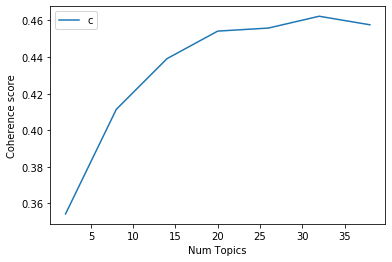

time: 386 ms


In [38]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
# optimal topic number=20

In [39]:
# Describe topics.
topics = ldaModel.describeTopics(10)
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)

[(0,
  '0.137*"video" + 0.053*"content" + 0.042*"show" + 0.030*"live" + '
  '0.026*"youtube" + 0.023*"watch" + 0.022*"tv" + 0.019*"web" + 0.018*"movie" '
  '+ 0.017*"medium"'),
 (1,
  '0.034*"web" + 0.031*"application" + 0.024*"service" + 0.024*"platform" + '
  '0.021*"software" + 0.018*"customer" + 0.017*"datum" + 0.017*"product" + '
  '0.016*"build" + 0.016*"developer"'),
 (2,
  '0.044*"feature" + 0.035*"page" + 0.027*"add" + 0.027*"user" + '
  '0.024*"version" + 0.021*"web" + 0.018*"file" + 0.017*"widget" + '
  '0.016*"browser" + 0.015*"create"'),
 (3,
  '0.048*"blog" + 0.045*"news" + 0.042*"post" + 0.031*"story" + '
  '0.031*"comment" + 0.025*"write" + 0.022*"reader" + 0.015*"content" + '
  '0.015*"link" + 0.014*"read"'),
 (4,
  '0.017*"issue" + 0.012*"case" + 0.008*"claim" + 0.008*"remove" + '
  '0.007*"state" + 0.007*"change" + 0.006*"clear" + 0.006*"make" + '
  '0.006*"term" + 0.006*"report"'),
 (5,
  '0.075*"app" + 0.057*"mobile" + 0.045*"game" + 0.042*"application" + '
  '0.04

In [95]:
def format_topics_sentences(ldamodel=ldaModel, corpus=corpus,post=post):
    # Init output
    post['topic']=0
    # Get main topic in each document
    for i,row in enumerate(ldamodel[corpus]):
        row1=row[0]
        row2 = sorted(row1,key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row2):
            if j == 0:  # => dominant topic
                return topic_num
format_topics_sentences_udf=F.udf(format_topics_sentences,StringType())
post11=post11.withColumn("topic",format_topics_sentences_udf(ldamodel=ldaModel, corpus=corpus))

/Users/yiyingwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


time: 1min 32s


In [101]:
post11.toPandas().to_csv('post_topicmodeling.csv')

time: 996 µs


# Writing Style Identification

### Load the posts data

In [0]:
posts = spark\
        .read\
        .option('header','false')\
        .option('inferSchema','true')\
        .csv(r'posts.csv')

In [0]:
colnames=['Post_ID','Title','Blogger_Name','Blogger_ID','Number of comments','Content','URL','Date',
          'Number of retrieved inlinks','Number of retrieved comments','Post Length words',
          'Post Length words no stopwords','Average word length characters',
          'Average word length characters no stopwords','MEIBI score','MEIBIX score']

In [0]:
i=0
for colname in colnames:
    to_replace_str = '_c'+str(i)
    posts = posts.withColumnRenamed(to_replace_str, colname)
    i += 1

In [0]:
posts.show()

+-------+--------------------+-----------------+----------+------------------+--------------------+--------------------+----------+---------------------------+----------------------------+-----------------+------------------------------+------------------------------+-------------------------------------------+-----------+------------+
|Post_ID|               Title|     Blogger_Name|Blogger_ID|Number of comments|             Content|                 URL|      Date|Number of retrieved inlinks|Number of retrieved comments|Post Length words|Post Length words no stopwords|Average word length characters|Average word length characters no stopwords|MEIBI score|MEIBIX score|
+-------+--------------------+-----------------+----------+------------------+--------------------+--------------------+----------+---------------------------+----------------------------+-----------------+------------------------------+------------------------------+-------------------------------------------+-----------+

In [0]:
#### functions to clean contents

In [0]:
def RemoveSpecialCHs(text):
    text = word_tokenize(text)
    st = [",", ".", "'", "!", '"', "#", "$", "%", "&", "(", ")", "*", "+", "-", ".", "/", ":", ";", "<", "=", '>', "?",
          "@", "[", "\\", "]", "^", "_", '`', "{", "|", "}", '~', '\t', '\n']

    words = [word for word in text if word not in st]
    return words

In [0]:
def syllable_count_Manual(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
            if word.endswith("e"):
                count -= 1
    if count == 0:
        count += 1
    return count

In [0]:
# COUNTS NUMBER OF SYLLABLES

def syllable_count(word):
    global cmuDictionary
    d = cmuDictionary
    try:
        syl = [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]][0]
    except:
        syl = syllable_count_Manual(word)
    return syl

### Functions to find  **Lexical Features:**
* Average Word Length
* Average Sentence Length By Word
* Average Sentence Length By Character
* Special Character Count
* Average Syllable per Word
* Functional Words Count
* Punctuation Count


These are the most basic features one can extract from the text. These features tell us about the structure of the text. For example averages of different counts like word lengths, special characters, punctuations and functional words etc. Functional words are used to express grammatical relationships among other words within a sentence. Secondly, if a word has more syllables then it is most likely to be a difficult word (although not necessary). Avg Syllable per word being the measure of complexity, is used in calculations of many other features related to readability scores described in the sections ahead. Punctuation Countand Special Character Count are straight forward ways to differentiate different genres. For example narrative story and research paper.

In [0]:
# removing stop words plus punctuation.
def Avg_wordLength(text):
    try:
        text.translate(string.punctuation)
        tokens = word_tokenize(text, language='english')
        st = [",", ".", "'", "!", '"', "#", "$", "%", "&", "(", ")", "*", "+", "-", ".", "/", ":", ";", "<", "=", '>', "?",
              "@", "[", "\\", "]", "^", "_", '`', "{", "|", "}", '~', '\t', '\n']
        stop = stopwords.words('english') + st
        words = [word for word in tokens if word not in stop]
        return float(np.average([len(word) for word in words]))
    except:
        return 0

In [0]:
find_feature = F.udf(lambda text: Avg_wordLength(text))
posts = posts.withColumn('meanwl', find_feature(F.col('Content')))

In [0]:
# returns avg number of words in a sentence
def Avg_SentLenghtByWord(text):
    try:
        tokens = sent_tokenize(text)
        return float(np.average([len(token.split()) for token in tokens]))
    except:
        return 0

In [0]:
find_feature = F.udf(lambda text: Avg_SentLenghtByWord(text))
posts = posts.withColumn('mean', find_feature(F.col('Content')))

In [0]:
# returns avg number of characters in a sentence
def Avg_SentLenghtByCh(text):
    try:
        tokens = sent_tokenize(text)
        return float(np.average([len(token) for token in tokens]))
    except:
        return 0

In [0]:
find_feature = F.udf(lambda text: Avg_SentLenghtByCh(text))
posts = posts.withColumn('meansl', find_feature(F.col('Content')))

In [0]:
# COUNTS SPECIAL CHARACTERS NORMALIZED OVER LENGTH OF CHUNK
def CountSpecialCharacter(text):
    try:
        st = ["#", "$", "%", "&", "(", ")", "*", "+", "-", "/", "<", "=", '>',
          "@", "[", "\\", "]", "^", "_", '`', "{", "|", "}", '~', '\t', '\n']
        count = 0
        for i in text:
            if (i in st):
                count = count + 1
        return float(count / len(text))
    except:
        return 0

In [0]:
find_feature = F.udf(lambda text: CountSpecialCharacter(text))
posts = posts.withColumn('means', find_feature(F.col('Content')))

In [0]:
# GIVES NUMBER OF SYLLABLES PER WORD
def Avg_Syllable_per_Word(text):
    try:
        tokens = word_tokenize(text, language='english')
        st = [",", ".", "'", "!", '"', "#", "$", "%", "&", "(", ")", "*", "+", "-", ".", "/", ":", ";", "<", "=", '>', "?",
              "@", "[", "\\", "]", "^", "_", '`', "{", "|", "}", '~', '\t', '\n']
        stop = stopwords.words('english') + st
        words = [word for word in tokens if word not in stop]
        syllabls = [syllable_count(word) for word in words]
        p = (" ".join(words))
        return float(sum(syllabls) / max(1, len(words)))
    except:
        return 0

In [0]:
find_feature = F.udf(lambda text: Avg_Syllable_per_Word(text))
posts = posts.withColumn('meanSyllable', find_feature(F.col('Content')))

In [0]:
# RETURNS NORMALIZED COUNT OF FUNCTIONAL WORDS FROM A Framework for
# Authorship Identification of Online Messages: Writing-Style Features and Classification Techniques

def CountFunctionalWords(text):
    try:
        functional_words = """a between in nor some upon
        about both including nothing somebody us
        above but inside of someone used
        after by into off something via
        all can is on such we
        although cos it once than what
        am do its one that whatever
        among down latter onto the when
        an each less opposite their where
        and either like or them whether
        another enough little our these which
        any every lots outside they while
        anybody everybody many over this who
        anyone everyone me own those whoever
        anything everything more past though whom
        are few most per through whose
        around following much plenty till will
        as for must plus to with
        at from my regarding toward within
        be have near same towards without
        because he need several under worth
        before her neither she unless would
        behind him no should unlike yes
        below i nobody since until you
        beside if none so up your
        """

        functional_words = functional_words.split()
        words = RemoveSpecialCHs(text)
        count = 0

        for i in text:
            if i in functional_words:
                count += 1

        return float(count / len(words))
    except:
        return 0

In [0]:
find_feature = F.udf(lambda text: CountFunctionalWords(text))
posts = posts.withColumn('f', find_feature(F.col('Content')))

In [0]:
def CountPuncuation(text):
    try:
        st = [",", ".", "'", "!", '"', ";", "?", ":", ";"]
        count = 0
        for i in text:
            if (i in st):
                count = count + 1
        return float(count) / float(len(text))
    except:
        return 0

In [0]:
find_feature = F.udf(lambda text: CountPuncuation(text))
posts = posts.withColumn('p', find_feature(F.col('Content')))

### Functions to find  **Vocabulary Richness Features:**
Many quantitative studies rely on the concept of vocabulary richness. A text has low vocabulary richness if the same limited vocabulary is repeated over and over again, while it has high vocabulary richness if new words continually appear. In essence, these features tell us about the diversity and richness of the vocabulary used in the text.

* Hapax Legomenon **V**
* Hapax DisLegemena(Sichel’s Measure) **V**
* Honores R Measure **V**
* Brunets Measure W **V** 
* Yules Characteristic K **V** 
* Shannon Entropy **V** （also readability feature）
* Simpson’s Index **V** （also readability feature）

In [0]:
# Hapax Legomenon
# TYPE TOKEN RATIO NO OF DIFFERENT WORDS / NO OF WORDS
def typeTokenRatio(text):
    try:    
        words = word_tokenize(text)
        return float(len(set(words)) / len(words))
    except:
        return 0

In [0]:
find_feature = F.udf(lambda text: typeTokenRatio(text))
posts = posts.withColumn('TTratio', find_feature(F.col('Content')))

In [0]:
# Hapax DisLegemena (Sichel’s Measure)
def hapaxDisLegemena(text):
    try:
        words = RemoveSpecialCHs(text)
        count = 0
        # Collections as coll Counter takes an iterable collapse duplicate and counts as
        # a dictionary how many equivelant items has been entered
        freqs = coll.Counter()
        freqs.update(words)
        for word in freqs:
            if freqs[word] == 2:
                count += 1

        h = float(count / float(len(words)))
        S = float(count / float(len(set(words))))
        return [S, h]
    except:
        return [0,0]

In [0]:
find_feature = F.udf(lambda text: hapaxDisLegemena(text)[0])
posts = posts.withColumn('SichelesMeasureS', find_feature(F.col('Content')))

In [0]:
find_feature = F.udf(lambda text: hapaxDisLegemena(text)[1])
posts = posts.withColumn('dihapax', find_feature(F.col('Content')))

In [0]:
# Honore Measure R
# return Honore Measure R
def hapaxLegemena(text):
    try:
        words = RemoveSpecialCHs(text)
        V1 = 0
        # dictionary comprehension . har word kay against value 0 kardi
        freqs = {key: 0 for key in words}
        for word in words:
            freqs[word] += 1
        for word in freqs:
            if freqs[word] == 1:
                V1 += 1
        N = len(words)
        V = float(len(set(words)))
        R = 100 * math.log(N) / max(1, (1 - (V1 / V)))
        h = V1 / N
        return [R, h]
    except:
            return [0,0]

In [0]:
find_feature = F.udf(lambda text: hapaxLegemena(text)[0])
posts = posts.withColumn('HonoreMeasureR', find_feature(F.col('Content')))

In [0]:
find_feature = F.udf(lambda text: hapaxLegemena(text)[1])
posts = posts.withColumn('hapax', find_feature(F.col('Content')))

In [0]:
# Brunets Measure W
# logW = V-a/log(N)
# N = total words , V = vocabulary richness (unique words) ,  a=0.17
# we can convert into log because we are only comparing different texts
def BrunetsMeasureW(text):
    try:
        words = RemoveSpecialCHs(text)
        a = 0.17
        V = float(len(set(words)))
        N = len(words)
        B = (V - a) / (math.log(N))
        return float(B)
    except:
        return 0

In [0]:
find_feature = F.udf(lambda text: BrunetsMeasureW(text))
posts = posts.withColumn('B', find_feature(F.col('Content')))

In [0]:
# K  10,000 * (M - N) / N**2
# , where M  Sigma i**2 * Vi.
def YulesCharacteristicK(text):
    try:
        words = RemoveSpecialCHs(text)
        N = len(words)
        freqs = coll.Counter()
        freqs.update(words)
        vi = coll.Counter()
        vi.update(freqs.values())
        M = sum([(value * value) * vi[value] for key, value in freqs.items()])
        K = 10000 * (M - N) / math.pow(N, 2)
        return float(K)
    except:
        return 0

In [0]:
find_feature = F.udf(lambda text: YulesCharacteristicK(text))
posts = posts.withColumn('YuleK', find_feature(F.col('Content')))

### Functions to find  **Readability Scores:**
Readability is the ease with which a reader can understand a written text. Readability is more than simply legibility—which is a measure of how easily a reader can distinguish individual letters or characters from each other. Features for readability stems from the field of linguistics and researchers have frequently used linguistics’ laws (e.g zipfs law) and lemmas to pull out the currently used features to calculate readability scores of text in the modern computer science. Following is the list of features we are using.

* Flesch Reading Ease **V**
* Flesch-Kincaid Grade Level **V**
* Gunning Fog Index  **V**
* Dale Chall Readability Formula  **V**
* Shannon Entropy (also vocabulary richness feature）**V**
* Simpson's Index (also vocabulary richness feature）**V**

In [0]:
def FleschReadingEase(text):
    try:
        NoOfSectences = len(sent_tokenize(text))
        words = RemoveSpecialCHs(text)
        l = float(len(words))
        scount = 0
        for word in words:
            scount += syllable_count(word)

        I = 206.835 - 1.015 * (l / float(NoOfsentences)) - 84.6 * (scount / float(l))
        return float(I)
    except:
        return 0

In [0]:
find_feature = F.udf(lambda text: FleschReadingEase(text))
posts = posts.withColumn('FR', find_feature(F.col('Content')))

In [0]:
def FleschCincadeGradeLevel(text):
    try:
        NoOfSectences = len(sent_tokenize(text))
        words = RemoveSpecialCHs(text)
        scount = 0
        for word in words:
            scount += syllable_count(word)

        l = len(words)
        F = 0.39 * (l / NoOfSentences) + 11.8 * (scount / float(l)) - 15.59
        return float(F)
    except:
        return 0

In [0]:
find_feature = F.udf(lambda text: FleschCincadeGradeLevel(text))
posts = posts.withColumn('FC', find_feature(F.col('Content')))

In [0]:
def GunningFoxIndex(text):
    try:
        NoOfSectences = len(sent_tokenize(text))
        words = RemoveSpecialCHs(text)
        NoOFWords = float(len(words))
        complexWords = 0
        for word in words:
            if (syllable_count(word) > 2):
                complexWords += 1

        G = 0.4 * ((NoOFWords / NoOfSentences) + 100 * (complexWords / NoOFWords))
        return float(G)
    except:
        return 0

In [0]:
find_feature = F.udf(lambda text: GunningFoxIndex(text))
posts = posts.withColumn('G', find_feature(F.col('Content')))

In [0]:
def dale_chall_readability_formula(text):
    try:
        NoOfSectences = len(sent_tokenize(text))
        words = RemoveSpecialCHs(text)
        difficult = 0
        adjusted = 0
        NoOfWords = len(words)
        with open('dale-chall.pkl', 'rb') as f:
            fimiliarWords = pickle.load(f)
        for word in words:
            if word not in fimiliarWords:
                difficult += 1
        percent = (difficult / NoOfWords) * 100
        if (percent > 5):
            adjusted = 3.6365
        D = 0.1579 * (percent) + 0.0496 * (NoOfWords / NoOfSectences) + adjusted
        return float(D)
    except:
        return 0

In [0]:
find_feature = F.udf(lambda text: dale_chall_readability_formula(text))
posts = posts.withColumn('D', find_feature(F.col('Content')))

In [0]:
# -1*sigma(pi*lnpi)
# Shannon and sympsons index are basically diversity indices for any community
def ShannonEntropy(text):
    try:
        words = RemoveSpecialCHs(text)
        lenght = len(words)
        freqs = coll.Counter()
        freqs.update(words)
        arr = np.array(list(freqs.values()))
        distribution = 1. * arr
        distribution /= max(1, lenght)
        import scipy as sc
        H = sc.stats.entropy(distribution, base=2)
        # H = sum([(i/lenght)*math.log(i/lenght,math.e) for i in freqs.values()])
        return float(H)
    except:
        return 0

In [0]:
find_feature = F.udf(lambda text: ShannonEntropy(text))
posts = posts.withColumn('Shannon', find_feature(F.col('Content')))

In [0]:
# 1 - (sigma(n(n - 1))/N(N-1)
# N is total number of words
# n is the number of each type of word
def SimpsonsIndex(text):
    try:
        words = RemoveSpecialCHs(text)
        freqs = coll.Counter()
        freqs.update(words)
        N = len(words)
        n = sum([1.0 * i * (i - 1) for i in freqs.values()])
        S = 1 - (n / (N * (N - 1)))
        return float(S)
    except:
        return 0

In [0]:
find_feature = F.udf(lambda text: SimpsonsIndex(text))
posts = posts.withColumn('S', find_feature(F.col('Content')))

In [0]:
print((posts.count(), len(posts.columns)))

(19464, 36)


In [0]:
posts.toPandas().to_csv('posts_match_writing_style.csv',index=False)

# Regression with MLlib

### Read all csv files produced before and combine them into one dataframe

In [68]:
# Load sentiment analysis results and assign correct names for corresponding column names
post_sentiment = spark.read.format("csv").option("header", "false").load("post_sentiment.csv")
post_sentiment = post_sentiment.withColumnRenamed("_c0", "Index")\
        .withColumnRenamed("_c1", "Post_ID")\
        .withColumnRenamed("_c2", "avg_senti_score")

time: 351 ms


In [69]:
# Load writing styles results and assign correct names for corresponding column names
post_feats_match = spark.read.format("csv").option("header", "false").load("posts_match_writing_style.csv")
post_feats_match = post_feats_match.select('_c0','_c1','_c5','_c9', '_c11','_c12','_c15','_c17',
                                           '_c18','_c19','_c20','_c21', '_c22','_c23','_c24','_c25', '_c26',
                                           '_c27','_c28','_c29', '_c30','_c31','_c32','_c33', '_c34','_c35','_c36')\
        .withColumnRenamed("_c0", "Index")\
        .withColumnRenamed("_c1", "Post_ID")\
        .withColumnRenamed("_c5", "Number of comments")\
        .withColumnRenamed("_c9", "Number of retrieved inlinks")\
        .withColumnRenamed("_c11", "Post Length (#words)")\
        .withColumnRenamed("_c12", "Post Length (#words no stopwords)")\
        .withColumnRenamed("_c15", "MEIBI score")\
        .withColumnRenamed("_c17", "meanwl")\
        .withColumnRenamed("_c18", "meansl")\
        .withColumnRenamed("_c19", "mean")\
        .withColumnRenamed("_c20", "meanSyllable")\
        .withColumnRenamed("_c21", "means")\
        .withColumnRenamed("_c22", "p")\
        .withColumnRenamed("_c23", "f")\
        .withColumnRenamed("_c24", "TTratio")\
        .withColumnRenamed("_c25", "hapax")\
        .withColumnRenamed("_c26", "HonoreMeasureR")\
        .withColumnRenamed("_c27", "dihapax")\
        .withColumnRenamed("_c28", "SichelesMeasureS")\
        .withColumnRenamed("_c29", "YuleK")\
        .withColumnRenamed("_c30", "S")\
        .withColumnRenamed("_c31", "B")\
        .withColumnRenamed("_c32", "Shannon")\
        .withColumnRenamed("_c33", "FR")\
        .withColumnRenamed("_c34", "FC")\
        .withColumnRenamed("_c35", "D")\
        .withColumnRenamed("_c36", "G")

time: 458 ms


In [70]:
# Load topic moodeling results and assign correct names for corresponding column names
post_topicmodeling = spark.read.format("csv").option("header", "false").load("post_topicmodeling.csv")
post_topicmodeling = post_topicmodeling.select('_c1', '_c17')
post_topicmodeling = post_topicmodeling.withColumnRenamed("_c1", "Post_ID")\
        .withColumnRenamed("_c17", "topic")
post_topicmodeling = post_topicmodeling.where("topic in ('1','2','3','4','5','6','7','8','9','10','11','12',\
                                              '13','14','15','16','17','18','19') ")

time: 295 ms


In [71]:
# Combine these dataframe together by Post_ID
all_feats = post_sentiment.join(post_feats_match, post_sentiment.Post_ID == post_feats_match.Post_ID).select(post_sentiment["*"],post_feats_match["*"]).drop(post_feats_match.Post_ID)
all_feats = all_feats.join(post_topicmodeling, all_feats.Post_ID == post_topicmodeling.Post_ID).select(all_feats["*"],post_topicmodeling["*"]).drop(post_topicmodeling.Post_ID)

time: 40 ms


In [72]:
# Eliminate the columns that we do not need.
all_feats = all_feats.drop('Index')
all_feats = all_feats.drop('Index')
all_feats = all_feats.drop('Post_ID')

time: 11.1 ms


In [73]:
all_feats.show(5)

+-------------------+------------------+---------------------------+--------------------+---------------------------------+-----------+-----------------+------------------+------------------+------------------+--------------------+--------------------+------------------+-------------------+-------------------+-----------------+--------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----+
|    avg_senti_score|Number of comments|Number of retrieved inlinks|Post Length (#words)|Post Length (#words no stopwords)|MEIBI score|           meanwl|            meansl|              mean|      meanSyllable|               means|                   p|                 f|            TTratio|              hapax|   HonoreMeasureR|             dihapax|   SichelesMeasureS|             YuleK|                 S|                 B|           Shannon|               FR|        

In [74]:
## Transfrom column into right type
cols = [ 'avg_senti_score', 'Number of comments', 'Number of retrieved inlinks', 'Post Length (#words)',
 'Post Length (#words no stopwords)', 'MEIBI score', 'meanwl', 'meansl', 'mean', 'meanSyllable', 'means',
 'p', 'f', 'TTratio', 'hapax', 'HonoreMeasureR', 'dihapax', 'SichelesMeasureS', 'YuleK', 'S', 'B', 'Shannon',
 'FR', 'FC', 'D', 'G','topic']
for col in cols:
    all_feats = all_feats.withColumn(col, all_feats[col].cast(DoubleType()))

time: 183 ms


In [75]:
all_feats.printSchema()

root
 |-- avg_senti_score: double (nullable = true)
 |-- Number of comments: double (nullable = true)
 |-- Number of retrieved inlinks: double (nullable = true)
 |-- Post Length (#words): double (nullable = true)
 |-- Post Length (#words no stopwords): double (nullable = true)
 |-- MEIBI score: double (nullable = true)
 |-- meanwl: double (nullable = true)
 |-- meansl: double (nullable = true)
 |-- mean: double (nullable = true)
 |-- meanSyllable: double (nullable = true)
 |-- means: double (nullable = true)
 |-- p: double (nullable = true)
 |-- f: double (nullable = true)
 |-- TTratio: double (nullable = true)
 |-- hapax: double (nullable = true)
 |-- HonoreMeasureR: double (nullable = true)
 |-- dihapax: double (nullable = true)
 |-- SichelesMeasureS: double (nullable = true)
 |-- YuleK: double (nullable = true)
 |-- S: double (nullable = true)
 |-- B: double (nullable = true)
 |-- Shannon: double (nullable = true)
 |-- FR: double (nullable = true)
 |-- FC: double (nullable = true)
 

### Build three different regression models and compare their performance: Linear Regression, Decision Tree Regression, and Random Forest Regression

In [31]:
# Look at the statistics of each variable
all_feats.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
avg_senti_score,18994,0.14574785456369205,0.08742542575999103,-1.0,1.0
Number of comments,18994,47.7158576392545,64.49944133956792,0.0,995.0
Number of retrieved inlinks,18948,10.893181338399831,113.40113759604314,0.0,15497.0
Post Length (#words),18953,377.83290244288503,416.6416495389561,1.0,11363.0
Post Length (#words no stopwords),18955,266.7200738591401,297.37768694760354,0.0,8119.0
MEIBI score,18961,14.32283896540266,124.5878637568447,0.0,7560.0
meanwl,18966,6.200211224891673,10.271334971967743,0.0,1318.0
meansl,18967,189.56863858138868,101.5260320578454,0.0,3504.0
mean,18968,30.533169344280488,23.163371746947316,0.0,2089.0


time: 2.29 s


### Draw the heatmap to show the correlation between independent variables:

In [33]:
from pyspark.ml.stat import Correlation

columns = all_feats.columns
assembler = VectorAssembler(inputCols=columns, 
                            outputCol="corr_features",handleInvalid='skip')
myGraph_vector = assembler.transform(all_feats).select("corr_features")
matrix = Correlation.corr(myGraph_vector, "corr_features")

time: 2.55 s


In [34]:
# Plot the correlation matrix
matrix = Correlation.corr(myGraph_vector, 'corr_features').collect()[0][0]
corrmatrix = matrix.toArray().tolist()

heatmap_df = pd.DataFrame(corrmatrix, index = columns, columns=columns)
heatmap_df = heatmap_df.round(3)
heatmap_df.head()

,avg_senti_score,Number of comments,Number of retrieved inlinks,Post Length (#words),Post Length (#words no stopwords),MEIBI score,meanwl,meansl,mean,meanSyllable,...,SichelesMeasureS,YuleK,S,B,Shannon,FR,FC,D,G,topic
avg_senti_score,1.000,-0.103,-0.047,0.005,0.008,-0.038,0.064,-0.001,-0.007,0.071,...,-0.022,0.017,0.004,0.007,0.005,-0.040,0.012,0.033,0.012,-0.092
Number of comments,-0.103,1.000,0.579,0.201,0.199,0.308,-0.105,-0.086,-0.079,-0.114,...,0.081,-0.186,0.005,0.239,0.161,0.138,-0.104,-0.134,-0.106,0.112
Number of retrieved inlinks,-0.047,0.579,1.000,0.166,0.165,0.231,-0.035,-0.039,-0.034,-0.043,...,0.077,-0.165,0.006,0.190,0.139,0.065,-0.048,-0.073,-0.048,0.050
Post Length (#words),0.005,0.201,0.166,1.000,0.999,0.078,-0.037,-0.013,-0.003,-0.001,...,0.204,-0.502,0.058,0.889,0.516,0.060,-0.019,-0.077,-0.015,0.067
Post Length (#words no stopwords),0.008,0.199,0.165,0.999,1.000,0.077,-0.031,-0.009,-0.001,0.005,...,0.203,-0.498,0.059,0.891,0.519,0.053,-0.014,-0.064,-0.011,0.060


time: 1.63 s


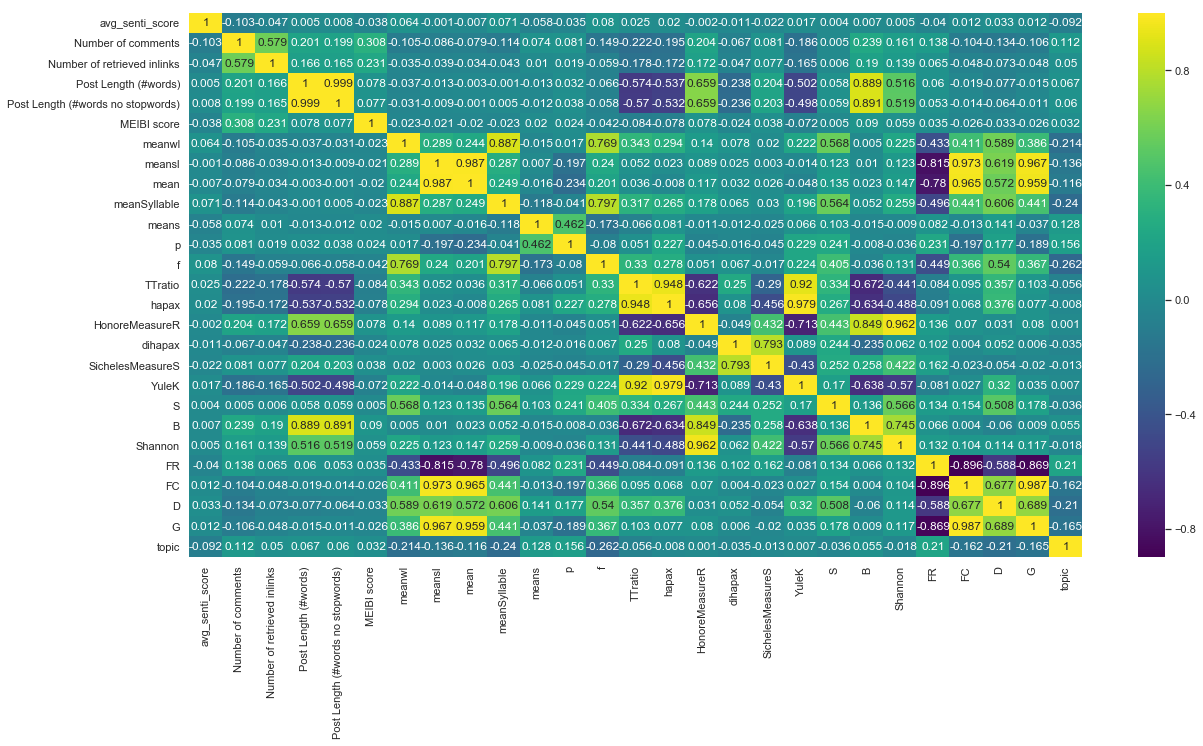

time: 1.92 s


In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(20,10)})
sns.heatmap(heatmap_df, annot=True, fmt="g", cmap='viridis')
plt.show()

#### From the heatmap above, we can notice that the the 'Post Length (#words)', and 'Post Length (#words no stopwords)' are very similar, so we only keep 'Post Length (#words)'.

#### For the Lexical Features: 'Average Word Length', 'Average Syllable per Word', and 'Functional Words Count'  are highly correlated; 'Average Sentence Length By Word' and 'Average Sentence Length By Character' is highly correlated; 'Shannon' stands for 'Shannon Entropy' and 'S' is the 'Simpson's Index', and they both reflects the diversity or diorder of the system , here we keep one of them. So for Lexical Features, we only keep 'Average Word Length', 'Average Sentence Length By Word', 'Special Character Count', 'Punctuation Count', and 'S'(Simposn's Index).

#### For Vocabulary Richness Features: 'TTratio' measures words richness,  'hapax' relect the number of words that show up only once,  'YuleK' depends on words with all frequencies, and 'HonoreMeasureR' dependens on 'hapax'; they are intuitively highly correlated; 'SichelesMeasureS' depends on 'dihapax', which is the number of words show up twice; so for Vocabulary Richness Features, we only keep 'TTratio', 'dihapax', and 'B'.

#### For Readability Scores: from the heatmap, it is obvious that 'FR', 'FC', 'D', 'G' are highly correlated. Thay are all features that measures the readbility of the text using different equations. So, we only keep 'D' , which has the lowest correlations with other independent variables.

#### Combine all features into one vector.

In [76]:
#Perfom on hot encoding for the 'topic' variable to transform it from categorical to numerical

all_feats = all_feats.na.drop(subset=["topic"])

topic_df = all_feats.select('topic')  

encoder = OneHotEncoder(inputCol="topic", outputCol="topic_vector")
encoded_df = encoder.transform(topic_df)

time: 906 ms


In [77]:
# transform from array to pyspark dataframe
x_3d = np.array(encoded_df.select('topic_vector').collect())
rows, idx, size = x_3d.shape
X = x_3d.reshape(rows, size)
X = X.tolist()

topic_encoded = sc.parallelize(X).toDF(('topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5','topic_6', 'topic_7',
                            'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13','topic_14', 'topic_15',
                            'topic_16', 'topic_17', 'topic_18'))
    

w = Window.orderBy("topic_0") 
topic_encoded = topic_encoded.withColumn("index", F.row_number().over(w))   
topic_encoded.show()

+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----+
|topic_0|topic_1|topic_2|topic_3|topic_4|topic_5|topic_6|topic_7|topic_8|topic_9|topic_10|topic_11|topic_12|topic_13|topic_14|topic_15|topic_16|topic_17|topic_18|index|
+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----+
|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|     0.0|     0.0|     0.0|     0.0|     0.0|     0.0|     1.0|     0.0|     0.0|    1|
|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|     0.0|     0.0|     0.0|     0.0|     0.0|     0.0|     1.0|     0.0|     0.0|    2|
|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|     0.0|     0.0|     0.0|     0.0|     0.0|     0.0|     0.0|     0.0|  

In [78]:
# Extract features that we need in the regression
cols=['avg_senti_score','Number of comments', 'Number of retrieved inlinks', 'Post Length (#words)', 
      'MEIBI score', 'meanwl', 'meansl','means','p','TTratio', 'dihapax', 'D','S']
reg_df = all_feats.select(cols)

w = Window.orderBy("avg_senti_score") 
reg_df = reg_df.withColumn("index", F.row_number().over(w))   
reg_df.show()

+--------------------+------------------+---------------------------+--------------------+-------------------+------------------+------------------+--------------------+--------------------+-------------------+--------------------+------------------+------------------+-----+
|     avg_senti_score|Number of comments|Number of retrieved inlinks|Post Length (#words)|        MEIBI score|            meanwl|            meansl|               means|                   p|            TTratio|             dihapax|                 D|                 S|index|
+--------------------+------------------+---------------------------+--------------------+-------------------+------------------+------------------+--------------------+--------------------+-------------------+--------------------+------------------+------------------+-----+
|                -1.0|               4.0|                        0.0|               280.0|                0.0| 5.939024390243903|235.42857142857142|0.019879518072289156|0.0

In [79]:
# Combine the encodede topic dataframe and the other columns
reg_df = reg_df.join(topic_encoded, reg_df.index == topic_encoded.index).select(reg_df["*"],topic_encoded["*"]).drop(topic_encoded.index)

reg_df.show()

+--------------------+------------------+---------------------------+--------------------+-------------------+------------------+------------------+--------------------+--------------------+-------------------+--------------------+------------------+------------------+-----+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|     avg_senti_score|Number of comments|Number of retrieved inlinks|Post Length (#words)|        MEIBI score|            meanwl|            meansl|               means|                   p|            TTratio|             dihapax|                 D|                 S|index|topic_0|topic_1|topic_2|topic_3|topic_4|topic_5|topic_6|topic_7|topic_8|topic_9|topic_10|topic_11|topic_12|topic_13|topic_14|topic_15|topic_16|topic_17|topic_18|
+--------------------+------------------+---------------------------+--------------------+-------------------+----------------

In [80]:
# Let us import the vector assembler
all_cols = reg_df.columns
all_cols.remove('index')
indept_cols = all_cols
indept_cols.remove('avg_senti_score')

assembler = VectorAssembler(inputCols=indept_cols,outputCol="features",handleInvalid='skip')

# Now let us use the transform method to transform our dataset
raw_data=assembler.transform(reg_df)
raw_data.show(truncate=False)

+--------------------+------------------+---------------------------+--------------------+-------------------+------------------+------------------+---------------------+--------------------+-------------------+--------------------+------------------+------------------+-----+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|avg_senti_score     |Number of comments|Number of retrieved inlinks|Post Length (#words)|MEIBI score        |meanwl            |meansl            |means                |p                   |TTratio            |dihapax             |D                 |S                 |index|topic_0|topic_1|topic_2|topic_3|topic_4|topic_5|topic_6|topic_7|topi

#### Standardize

In [83]:
# Since from above statistics, we find that the the scales of varibales vary a lot, and this will influence the result of
#regression, so we do the standardization before regression
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
raw_data=standardscaler.fit(raw_data).transform(raw_data)
raw_data.select("features","Scaled_features").show(5)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|(31,[0,2,4,5,6,7,...|(31,[0,2,4,5,6,7,...|
|(31,[0,1,2,3,4,5,...|(31,[0,1,2,3,4,5,...|
|(31,[0,2,4,5,6,7,...|(31,[0,2,4,5,6,7,...|
|(31,[0,2,4,5,6,7,...|(31,[0,2,4,5,6,7,...|
|(31,[0,1,2,3,4,5,...|(31,[0,1,2,3,4,5,...|
+--------------------+--------------------+
only showing top 5 rows

time: 6.05 s


#### Train-test split

In [84]:
# Get the dataframe used for regression
df_lr = raw_data.select('Scaled_features', 'avg_senti_score')
df_lr = df_lr.withColumnRenamed("Scaled_features","features")
df_lr = df_lr.withColumnRenamed("avg_senti_score","label")

time: 16.9 ms


In [85]:
train, test = df_lr.randomSplit([0.7, 0.3], seed=2020)

time: 20 ms


In [86]:
train.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)

time: 1e+03 µs


### Below we try to use three different regression techniques:

### Linear Regression

#### First, we use cross validation to find the best hyper-parameters for the linear regression.

In [87]:
evaluator = RegressionEvaluator(metricName="mae")
lr = LinearRegression()
grid = ParamGridBuilder().addGrid(lr.maxIter, [500]) \
                                .addGrid(lr.regParam, [0]) \
                                .addGrid(lr.elasticNetParam, [1]) \
                                .build()
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, \
                        evaluator=evaluator, numFolds=3)
lrModel = lr_cv.fit(train)
bestModel = lrModel.bestModel

time: 38 s


In [88]:
print('Best Param (regParam): ', bestModel._java_obj.getRegParam())
print('Best Param (MaxIter): ', bestModel._java_obj.getMaxIter())
print('Best Param (elasticNetParam): ', bestModel._java_obj.getElasticNetParam())

Best Param (regParam):  0.0
Best Param (MaxIter):  500
Best Param (elasticNetParam):  1.0
time: 1.98 ms


#### Then we feed these parameters into the linear regression model.

In [89]:
lr = LinearRegression(featuresCol = 'features', labelCol='label', maxIter=500, regParam=0, elasticNetParam=1)
lr_model = lr.fit(train)
test_result = lr_model.evaluate(test)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 0.0838456
time: 22.4 s


In [95]:
#Display the variable name - coefficient pairs
coefs = list(lr_model.coefficients)
coefs_dict = {indept_cols[idx]:coefs[idx] for idx in range(len(indept_cols))}
print("Coefficients: " + str(coefs_dict))
print("Intercept: " + str(lr_model.intercept))

Coefficients: {'Number of comments': -0.008023643767639439, 'Number of retrieved inlinks': 0.0003429311424888498, 'Post Length (#words)': 0.0026070928582002393, 'MEIBI score': -0.0005117084255139149, 'meanwl': 0.005886563956750214, 'meansl': -0.00497742451980379, 'means': -0.003927271018632092, 'p': -0.0018724251738373191, 'TTratio': -0.0006997417106136013, 'dihapax': -0.0005071156218841905, 'D': 0.0035860783743503918, 'S': -0.0034370822219810904, 'topic_0': 0.0, 'topic_1': 0.00024880141926524166, 'topic_2': 0.0, 'topic_3': -0.002132297556777832, 'topic_4': -0.0006217483899352037, 'topic_5': -0.006910810708944812, 'topic_6': -0.0008408980056145487, 'topic_7': 0.000262923065957027, 'topic_8': -0.004387221855288434, 'topic_9': -0.0061310860062500985, 'topic_10': -0.00894986884412383, 'topic_11': -0.0007175952903287266, 'topic_12': -0.008578153765459218, 'topic_13': -0.00287863494361141, 'topic_14': -0.004359186453918525, 'topic_15': -0.006084465919303701, 'topic_16': -0.01152579772505239

### Decision tree regression

In [96]:
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'label')
dt_model = dt.fit(train)
dt_predictions = dt_model.transform(test)
dt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.0835066
time: 9.28 s


### Gradient-boosted tree regression

In [97]:
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'label', maxIter=10)
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)
gbt_predictions.select('prediction', 'label', 'features').show(5)

+-------------------+-------------------+--------------------+
|         prediction|              label|            features|
+-------------------+-------------------+--------------------+
|  0.163946044541538| 0.1219085401722363|(31,[0,1,2,3,4,5,...|
| 0.1565488466407375|0.18633132844286807|(31,[0,1,2,3,4,5,...|
|0.13874395766493378| 0.3144995210611302|(31,[0,1,2,3,4,5,...|
|0.14164489713246697| 0.1464404766995679|(31,[0,1,2,3,4,5,...|
|0.14943374163949924| 0.1399631383583734|(31,[0,1,2,3,4,5,...|
+-------------------+-------------------+--------------------+
only showing top 5 rows

time: 17.5 s


In [98]:
gbt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.0832831
time: 3.17 s


#### Among the above three methond, we found that the decision tree has the lowest Root Mean Squared Error value, so we choose this model.

### Explore the features that are important for blogs' influence

In [27]:
# Arraneg the features from most important to least important
feat_importance = dt_model.featureImportances.toArray().tolist()
feat_importance_dict = {feat_importance[i]:i for i in range(len(feat_importance))}
sorted_items = sorted(feat_importance_dict.items(),reverse=True)
sorted_items

[(0.11065752757044363, 0),
 (0.08365202590486413, 1),
 (0.08333551189486661, 3),
 (0.0773592872568921, 12),
 (0.07583293138155231, 2),
 (0.06864270329624475, 9),
 (0.06770801421035372, 4),
 (0.06214688236217471, 5),
 (0.06178188352074915, 10),
 (0.05941287042207795, 11),
 (0.0575779332062285, 7),
 (0.053972003063482835, 8),
 (0.04566376686759709, 6),
 (0.02303727169502505, 18),
 (0.01677111516969091, 21),
 (0.01237139988626356, 28),
 (0.010244684508753366, 22),
 (0.00869655246142283, 17),
 (0.00533052239171538, 25),
 (0.005110659968241901, 24),
 (0.004669454844473141, 29),
 (0.002365136259568941, 20),
 (0.002296335552552195, 26),
 (0.0013635263047651134, 19),
 (0.0, 30)]

time: 30 ms


In [28]:
#Display the variable names corresponding to index
cols_dict = {idx:indept_cols[idx] for idx in range(len(indept_cols))}
cols_dict

{0: 'Number of comments',
 1: 'Number of retrieved inlinks',
 2: 'Post Length (#words)',
 3: 'MEIBI score',
 4: 'meanwl',
 5: 'meansl',
 6: 'means',
 7: 'p',
 8: 'TTratio',
 9: 'dihapax',
 10: 'D',
 11: 'S',
 12: 'topic_0',
 13: 'topic_1',
 14: 'topic_2',
 15: 'topic_3',
 16: 'topic_4',
 17: 'topic_5',
 18: 'topic_6',
 19: 'topic_7',
 20: 'topic_8',
 21: 'topic_9',
 22: 'topic_10',
 23: 'topic_11',
 24: 'topic_12',
 25: 'topic_13',
 26: 'topic_14',
 27: 'topic_15',
 28: 'topic_16',
 29: 'topic_17',
 30: 'topic_18'}

time: 3 ms


#### We set 0.5 as the importance threshold, then we can can tell from above results that features 0(Number of comments), 1(Number of retrieved inlinks), 3(MEIBI score), 12(topic_0), 2(Post Length (#words)), 9(dihapax), 4(meanwl), 5(meansl), 10(D), 11('S'), 7(p), 8(TTratio) are 12 most important features.